In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_area, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


In [4]:
pl.rcParams['axes.labelsize']

16.0

# Dataset info

In [5]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Responsive params
responsive_test = 'nstds' # 'nstds' #'ROC' #None
nstd_thr=10
responsive_thr = nstd_thr if responsive_test=='nstds' else 0.05 #0.05 #None
n_stds = None if responsive_test=='ROC' else 2.5 #None

response_type = 'dff'

response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
print(response_str)

dff_nstds-thr-10.00


In [6]:
#### Create data ID for labeling figures with data-types
experiment = 'blobs'


# Output dir

In [7]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

In [8]:
pupildir = os.path.join(aggregate_dir, 'behavior-state', 'pupil')
print(pupildir)

if not os.path.exists(pupildir):
    os.makedirs(pupildir)

/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/pupil


#### Get metadata for stimulus

In [9]:
experiment = 'blobs'

In [10]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata['datakey'] = ['%s_%s_fov%i' % (session, animalid, fovnum) \
                        for session, animalid, fovnum in sdata[['session', 'animalid', 'fovnum']].values]

sdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,26,26,26
Lm,22,22,22
V1,18,18,18


In [22]:
# Get blob metadata only - and only if have RFs
sdata_exp = pd.concat([g for k, g in sdata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)) ]).reset_index(drop=True)

sdata_exp[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,13,13,13
Lm,12,12,12
V1,11,11,11


#### Drop duplicates and whatnot fovs

In [23]:
stim_filterby = 'first'

if experiment=='blobs':
    has_gratings=False
    g_str = 'hasgratings' if has_gratings else 'blobsonly'
else:
    g_str = 'gratingsonly'
resp_filter_str = 'stim-filter-%s_%s_%s' % (stim_filterby, g_str, response_str)

In [24]:
# Drop duplicates and whatnot fovs
if experiment=='blobs':
    exp_dkeys = aggr.get_blob_datasets(filter_by=stim_filterby, has_gratings=has_gratings, as_dict=True)
elif experiment == 'gratings':
    exp_dkeys = aggr.get_gratings_datasets(filter_by=stim_filterby, as_dict=True)

dictkeys = [d for d in list(itertools.chain(*exp_dkeys.values()))]
stim_datakeys = ['%s_%s_fov%i' % (s.split('_')[0], s.split('_')[1], 
                   sdata[(sdata['animalid']==s.split('_')[1]) & (sdata['session']==s.split('_')[0])]['fovnum'].unique()[0]) for s in dictkeys]
expmeta = dict((k, [dv for dv in stim_datakeys for vv in v if vv in dv]) for k, v in exp_dkeys.items())

curr_sdata = sdata_exp[sdata_exp['datakey'].isin(stim_datakeys)].copy().reset_index(drop=True)
print('[%s] %i unique datakeys' % (experiment, len(stim_datakeys)))
curr_sdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

[blobs] 25 unique datakeys


,animalid,session,fov
visual_area,,,
Li,9,9,9
Lm,8,8,8
V1,8,8,8


In [25]:
#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, resp_filter_str])
print(data_id)


traces001|stim-filter-first_blobsonly_dff_nstds-thr-10.00


In [26]:
curr_sdata.shape, sdata_exp.shape

((98, 7), (141, 7))

# Load gratings or blobs

In [15]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, response_type)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-15.00_dff_stimulus.pkl']

In [16]:
aggr_trialmeans_dfile = glob.glob(os.path.join(stats_dir, 
                                'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, response_type)))[0]

print(aggr_trialmeans_dfile)
with open(aggr_trialmeans_dfile, 'rb') as f:
    MEANS = pkl.load(f)
    

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl


In [19]:
# glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s*_%s_baseline.pkl' 
#                                                % (experiment, responsive_test, response_type)))

In [20]:
# aggr_baselines_dfile = glob.glob(os.path.join(stats_dir, 
#                                 'aggr_%s_trialmeans_*%s*_%s_baseline.pkl'
#                                               % (experiment, responsive_test, response_type)))[0]

# print(aggr_baselines_dfile)
# with open(aggr_baselines_dfile, 'rb') as f:
#     BAS = pkl.load(f)

# Face tracker data

In [17]:
#### Set source/dst paths
dlc_home_dir = '/n/coxfs01/julianarhee/face-tracking'
dlc_project = 'facetracking-jyr-2020-01-25' #'sideface-jyr-2020-01-09'
dlc_project_dir = os.path.join(dlc_home_dir, dlc_project)

dlc_video_dir = os.path.join(dlc_home_dir, dlc_project, 'videos')
dlc_results_dir = os.path.join(dlc_project_dir, 'pose-analysis') # DLC analysis output dir

#### Training iteration info
dlc_projectid = 'facetrackingJan25'
scorer='DLC_resnet50'
iteration = 1
shuffle = 1
trainingsetindex=0
videotype='.mp4'
snapshot = 391800 #430200 #20900
DLCscorer = '%s_%sshuffle%i_%i' % (scorer, dlc_projectid, shuffle, snapshot)
print("Extracting results from scorer: %s" % DLCscorer)

Extracting results from scorer: DLC_resnet50_facetrackingJan25shuffle1_391800


#### Check which datakeys are missing DLC -- ALL data

In [18]:
print("Checking for existing results: %s" % dlc_results_dir)
dlc_runkeys = list(set([ os.path.split(f)[-1].split('DLC')[0] \
                       for f in glob.glob(os.path.join(dlc_results_dir, '*.h5'))]))
dlc_analyzed_experiments = ['_'.join(s.split('_')[0:4]) for s in dlc_runkeys]

# Get sdata indices that have experiments analyzed
ixs_wth_dlc = [i for i in sdata.index.tolist() 
                if '%s_%s' % (sdata.loc[i]['datakey'], sdata.loc[i]['experiment']) in dlc_analyzed_experiments]
dlc_dsets = sdata.iloc[ixs_wth_dlc]

dlc_datakeys = dlc_dsets['datakey'].unique()
sdata_datakeys = sdata['datakey'].unique()
print("%i of %i datasets with DLC." % (len(dlc_datakeys),len(sdata_datakeys)))


Checking for existing results: /n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/pose-analysis
34 of 66 datasets with DLC.


In [19]:
glob.glob(os.path.join(dlc_project_dir, 'dlc-models', 'iteration-%i' % iteration,\
                      '%s-trainset95shuffle%i' % (dlc_projectid, shuffle), 'train', 'snapshot-%i.meta' % snapshot))


['/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/dlc-models/iteration-1/facetrackingJan25-trainset95shuffle1/train/snapshot-391800.meta']

In [27]:
# Get sdata indices that have experiments analyzed
ixs_wth_dlc = [i for i in sdata_exp.index.tolist() 
                if '%s_%s' % (sdata_exp.loc[i]['datakey'], sdata_exp.loc[i]['experiment']) in dlc_analyzed_experiments]
dsets = sdata_exp.iloc[ixs_wth_dlc]

dlc_datakeys = dsets['datakey'].unique()
exp_datakeys = sdata_exp['datakey'].unique()
print("%i of %i datasets with DLC." % (len(dlc_datakeys),len(exp_datakeys)))
missing_dlc = [i for i in exp_datakeys if i not in dlc_datakeys]
print("Need %i datasets analyzed:" % len(missing_dlc), missing_dlc)

34 of 36 datasets with DLC.
('Need 2 datasets analyzed:', ['20191008_JC091_fov1', '20190618_JC097_fov1'])


#### Only include dsets with face-tracking

In [20]:
print("Checking for existing results: %s" % dlc_results_dir)
dlc_runkeys = list(set([ os.path.split(f)[-1].split('DLC')[0] \
                       for f in glob.glob(os.path.join(dlc_results_dir, '*.h5'))]))
dlc_analyzed_experiments = ['_'.join(s.split('_')[0:4]) for s in dlc_runkeys]

# Get sdata indices that have experiments analyzed
ixs_wth_dlc = [i for i in curr_sdata.index.tolist() 
                if '%s_%s' % (curr_sdata.loc[i]['datakey'], curr_sdata.loc[i]['experiment']) in dlc_analyzed_experiments]
dsets = curr_sdata.iloc[ixs_wth_dlc]

dlc_datakeys = dsets['datakey'].unique()
exp_datakeys = curr_sdata['datakey'].unique()
print("%i of %i datasets with DLC." % (len(dlc_datakeys),len(exp_datakeys)))
missing_dlc = [i for i in exp_datakeys if i not in dlc_datakeys]
print("Need %i datasets analyzed:" % len(missing_dlc), missing_dlc)

Checking for existing results: /n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/pose-analysis
24 of 25 datasets with DLC.
('Need 1 datasets analyzed:', ['20190618_JC097_fov1'])


#### Loading existing extracted pupil data

In [28]:
bstate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state'
pupil_fpath = glob.glob(os.path.join(bstate_dir, '%s_pupil-traces_snapshot-%i.pkl' % (experiment, snapshot)))[0]
print(pupil_fpath)

# This is a dict, keys are datakeys
with open(pupil_fpath, 'rb') as f:
    PUPIL = pkl.load(f)

/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/blobs_pupil-traces_snapshot-391800.pkl


In [29]:
[i for i in exp_datakeys if '%s_%s' % (i, experiment) not in PUPIL.keys()]

['20190502_JC076_fov1',
 '20191008_JC091_fov1',
 '20190617_JC097_fov1',
 '20190618_JC097_fov1']

# Load traces

In [30]:
from scipy import interpolate
def resample_traces(samples, in_rate=44.65, out_rate=20.0):

    n_in_samples= len(samples)
    in_samples = samples.copy() #[rid, :] #np.array(tracef['File%03d' % curr_file][trace_type][:])
    in_tpoints = np.arange(0, n_in_samples) #len(in_samples))

    n_out_samples = round(n_in_samples * out_rate/in_rate)
    #print("N out samples: %i" % n_out_samples)

    flinear = interpolate.interp1d(in_tpoints, in_samples, axis=0)

    out_tpoints = np.linspace(in_tpoints[0], in_tpoints[-1], n_out_samples)
    out_samples = flinear(out_tpoints)
    #print("Out samples:", out_samples.shape)
    
    return out_tpoints, out_samples

def resample_pupil_traces(pupiltraces, in_rate=20.0, out_rate=22.325, min_nframes=None):
    pupildfs = []
    if min_nframes is None:
        min_nframes = int(round(np.mean([len(g) for p, g in pupiltraces.groupby(['trial'])])))
    #print(min_nframes)
    for trial, g in pupiltraces.groupby(['trial']):
        if len(g['pupil']) < min_nframes:
            npad = min_nframes - len(g['pupil'])
            vals = np.pad(g['pupil'].values, pad_width=((0, npad)), mode='edge')
        else:
            vals = g['pupil'].values[0:min_nframes]
        #print(len(vals))
        _, out_s = resample_traces(vals, in_rate=in_rate, out_rate=out_rate)
        currconfig = g['config'].unique()[0]
        pupildfs.append(pd.DataFrame({'pupil': out_s, 
                                       'config': [currconfig for _ in np.arange(0, len(out_s))],
                                       'trial': [trial for _ in np.arange(0, len(out_s))]} ))
    pupildfs = pd.concat(pupildfs, axis=0).reset_index(drop=True)
    return pupildfs


def zscore_array(v):
    return (v-v.mean())/v.std()

# Select dataset (example FOV)

In [31]:
include_stimuli='all'

animalid = 'JC097'
session = '20190616'
fovnum = 1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

if experiment == 'blobs':
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
else:
    obj = util.Gratings(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()
print(sdf.shape)

Creating blobs object [JC097|20190616|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
(50, 8)


In [32]:
all_configs = ['config%03d' % i for i in np.arange(1, sdf.shape[0]+1)]
if experiment=='blobs':
    control_configs = ['config001', 'config002', 'config003', 'config004', 'config005']
elif experiment=='gratings':
    control_configs = sdf[sdf['size']>100].index.tolist()
    
if include_stimuli=='fullscreen':
    included_configs = [c for c in all_configs if c in control_configs]
elif include_stimuli=='image':
    included_configs = [c for c in all_configs if c not in control_configs]
elif include_stimuli=='all':
    included_configs = all_configs
else:
    print("UNKNOWN: %s" % include_stimuli)
print("Restricting stimuli to: %s (%i conditions)" % (include_stimuli, len(included_configs)))

Restricting stimuli to: all (50 conditions)


In [33]:
# Get neural means
print(datakey)
neuraldf = MEANS[datakey].copy()
print(neuraldf.shape)

# Get pupil traces
pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()
pupiltraces.head()


20190616_JC097_fov1
(1500, 297)


,config,pupil,trial
0,config004,33.363709,1
1,config004,33.359263,1
2,config004,33.837850,1
3,config004,34.106828,1
4,config004,29.055174,1


# Downsample and align traces

In [34]:
print("Loading <%s> traces: test=%s, thr=%.3f" % (response_type, responsive_test, responsive_thr))


Loading <dff> traces: test=nstds, thr=10.000


In [35]:
print("Loading <%s> traces: test=%s, thr=%.3f" % (response_type, responsive_test, responsive_thr))

#### Load traces of responsive cells
traces, labels, sdf = aggr.load_traces(animalid, session, fovnum, experiment, traceid=traceid, 
                                         response_type=response_type,
                                         responsive_test=responsive_test, 
                                         responsive_thr=responsive_thr)
trial_key = dict((int(t[5:]), g['config'].unique()[0]) for t, g in labels.groupby(['trial']))
roi_list = traces.columns.tolist()

Loading <dff> traces: test=nstds, thr=10.000
Creating blobs object [JC097|20190616|FOV1_zoom2p0x|traces001]
... exp.load()
... loading saved data array (dff).
... updating self
... getting responsive cells (test: nstds, thr: 10.00')
... loading stats
296 of 432 cells responsive


In [37]:
# Get trial alignment info
alignment_info = aggr.get_trial_alignment(animalid, session, fovnum, experiment, traceid=traceid)
# alignment_info

In [38]:
# Temporal binning params
new_framerate = 20.0
framerate = 44.65

#n_frames_bin = np.ceil(framerate/new_framerate) #11.
#new_framerate = (framerate/n_frames_bin)
print("Downsampled fr: %.2f Hz" % new_framerate)


#### Get trial epochs
stim_on = float(labels['stim_on_frame'].unique())
n_on = float(labels['nframes_on'].unique())
iti_pre = float(alignment_info['iti_pre'])
iti_post = float(alignment_info['iti_post'])
stim_dur = stim_on/framerate

#### Get indices of trial epochs to model
pre_flank = round((iti_pre)*44.65) #n_on/2.
post_flank = round((iti_post)*44.65)  #n_on

# start_ix = int(stim_on-pre_flank)
# end_ix = int(stim_on + n_on + post_flank + 1)
# print(start_ix, end_ix, end_ix-start_ix)


Downsampled fr: 20.00 Hz


In [101]:
# Check with known config, known RID
# rid=90
# ml=40 #-1
# sz=20

rid=120
ml=27
sz=50

# Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                        index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
included_trials = [trial for trial, tg in labels.groupby(['trial'])]

#### Get resampled indices of trial epochs
nframes_per_trial = trialmat.shape[1]
out_tpoints, out_ixs = resample_traces(np.arange(0, nframes_per_trial), in_rate=framerate, out_rate=new_framerate)
new_stim_on = int(np.where(abs(out_ixs-stim_on) == min(abs(out_ixs-stim_on)))[0])
print(new_stim_on)
new_n_on = int(round( stim_dur*new_framerate))
print(new_n_on)


#### Bin traces - Each tbin is a column, each row is a sample 
df = trialmat.fillna(method='pad').copy().T
#df['frame_ix'] = df.index.tolist()
xdf = df.reindex(df.index.union(out_ixs)).interpolate('values').loc[out_ixs]
binned_trialmat = xdf.T
n_tbins = binned_trialmat.shape[1]
# binned_trialmat = sample_data.T.groupby(np.arange(len(sample_data.columns))//n_frames_bin, axis=0).mean().T
# n_tbins = np.ceil(trialmat.shape[1] / n_frames_bin)

#### Zscore traces 
zscored_neural = binned_trialmat / binned_trialmat.values.ravel().std()

# Reshape roi traces
cfg_list = np.hstack([[c for _ in np.arange(0, n_tbins)] for c in configs_on_included_trials])
r_ = zscored_neural.T.unstack().reset_index() # level_0=trial number, level_1=frame number
r_.rename(columns={'level_0': 'trial', 'level_1': 'frame_ix', 0: rid}, inplace=True)
r_['config'] = cfg_list
#r_list.append(r_)

print(trialmat.shape, binned_trialmat.shape)


20
20
((1500, 135), (1500, 60))


In [102]:
included_trial_nums = sorted(pupiltraces['trial'].unique())

#print(sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)])
cfg = sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)].index[0]
trial_ixs_currcfg = np.array([int(t[5:]) for t in labels[labels['config']==cfg]['trial'].unique()])
trial_ixs = np.array([t for t in trial_ixs_currcfg if t in included_trial_nums])
print("[%s] plotting %i of %i trials" % (cfg, len(trial_ixs), len(trial_ixs_currcfg)))

[config020] plotting 30 of 30 trials


In [109]:
sdf.loc[cfg]

color                
morphlevel         27
object        morph27
size               50
stimtype        image
xpos               25
ypos               -5
yrot                0
Name: config020, dtype: object

### Test traces

((1500, 135), (1500, 60))


<IPython.core.display.Javascript object>


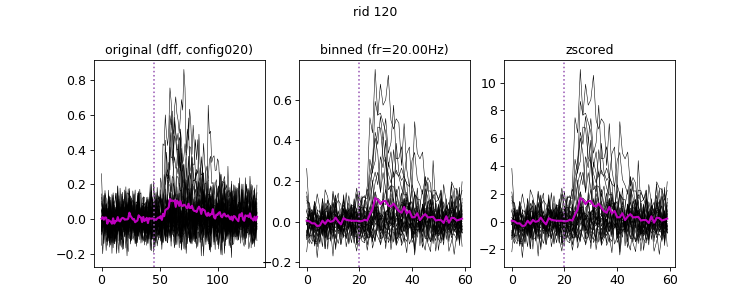

Text(0.5,0.98,u'rid 120')

In [104]:
print(trialmat.shape, binned_trialmat.shape)
#raw_ = trialmat.loc[included_trial_nums].copy()
#binned_ = binned_trialmat.loc[included_trial_nums].copy()
#zscored_ = zscored_neural.loc[included_trial_nums].copy()

fig, axn = pl.subplots(1, 3, figsize=(10,4))
ax=axn[0]; ax.set_title('original (%s, %s)' % (response_type, cfg));
ax.plot(trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(trialmat.loc[trial_ixs].values.T, axis=1), 'm', lw=2)
ax.axvline(x=stim_on, ls=':')

ax=axn[1]; ax.set_title('binned (fr=%.2fHz)' % (new_framerate));
ax.plot(binned_trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(binned_trialmat.loc[trial_ixs].values.T, axis=1), 'm', lw=2)
ax.axvline(x=new_stim_on, ls=':')


ax=axn[2]; ax.set_title('zscored');
ax.plot(zscored_neural.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(zscored_neural.loc[trial_ixs].values.T, axis=1), 'm', lw=2)
ax.axvline(x=new_stim_on, ls=':')
pl.subplots_adjust(top=0.8)
pl.suptitle('rid %i' % rid)


#### Match pupil framerate

In [105]:
len(out_ixs)

60

In [106]:
print(new_framerate)
#### Resample pupil
desired_nframes = len(out_ixs) # 60
binned_pupil = resample_pupil_traces(pupiltraces, in_rate=20.0, out_rate=new_framerate, 
                                     min_nframes=desired_nframes)


pupil_trialmat = pd.DataFrame(np.vstack([p['pupil'].values for trial, p in binned_pupil.groupby(['trial'])]),
                              index=binned_trialmat.index, columns=binned_trialmat.columns)
print(pupil_trialmat.shape)


20.0
(1500, 60)


<IPython.core.display.Javascript object>


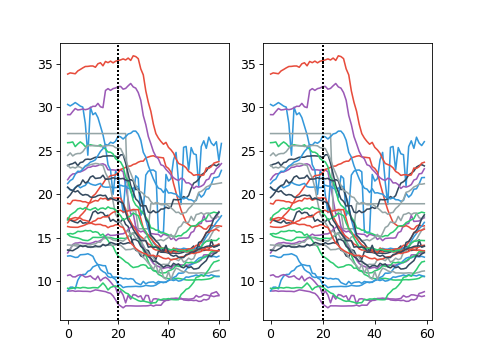

In [107]:
fig, axn = pl.subplots(1, 2)
ax=axn[0]
for t, pg in pupiltraces[pupiltraces['config']==cfg].groupby(['trial']):
    ixs = np.arange(0, len(pg['pupil'].values))
    ax.plot(ixs, pg['pupil'].values)
    ax.axvline(x=new_stim_on, ls=':', color='k')
    
ax=axn[1]
for t, pg in binned_pupil[binned_pupil['config']==cfg].groupby(['trial']):
    ixs = np.arange(0, len(pg['pupil'].values))
    ax.plot(ixs, pg['pupil'].values)
    ax.axvline(x=new_stim_on, ls=':', color='k')

In [320]:
binned_pupil.max(), binned_pupil.min()

(config    config050
 pupil       44.9172
 trial          1500
 dtype: object, config    config001
 pupil       5.78824
 trial             1
 dtype: object)

In [108]:
sdf_list = sdf.index.tolist()
cfg_array = np.reshape(sdf_list, (10,5)).T
ri, ci = np.where(cfg_array=='config002')[0:]
print(ri, ci)

(array([1]), array([0]))


<IPython.core.display.Javascript object>


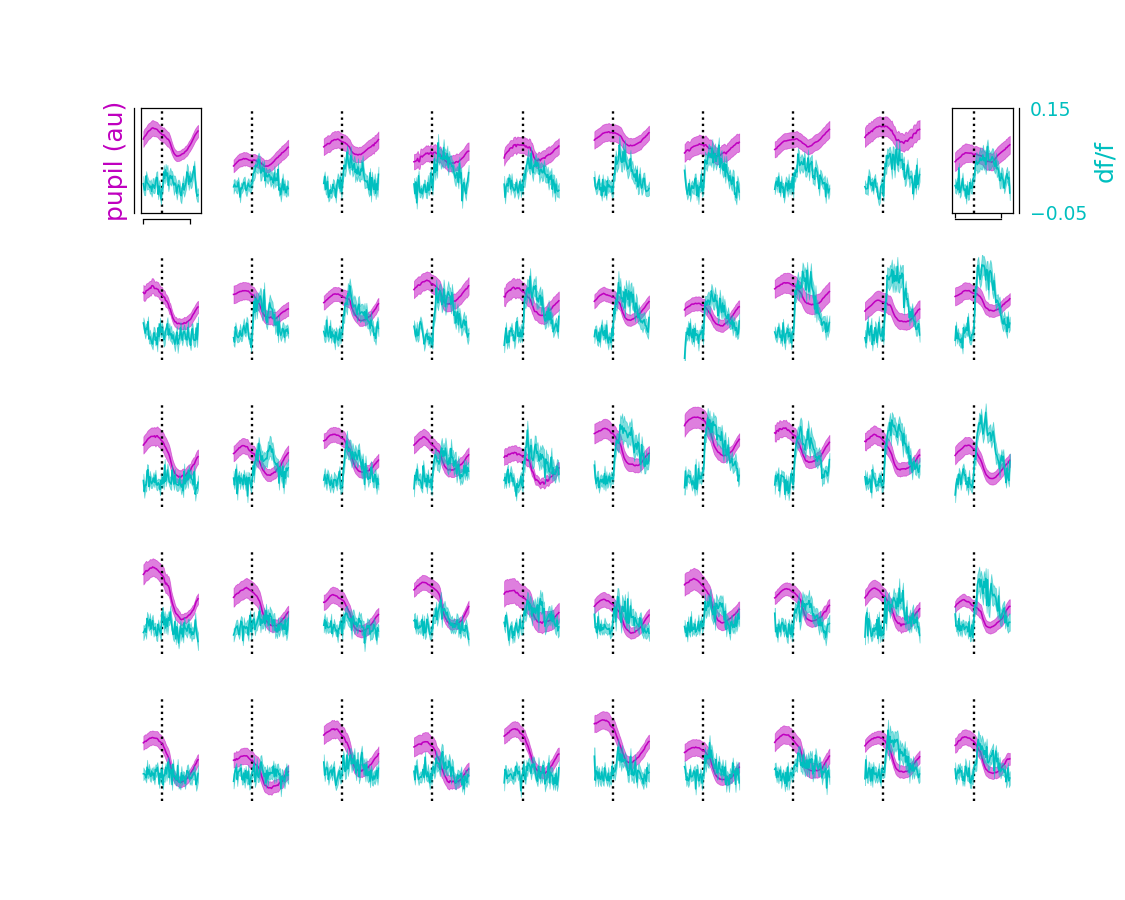

In [51]:
neural_color = 'c'
pupil_color = 'm'

fig, axn = pl.subplots(5, 10, sharex=True, sharey=True, figsize=(10,8), dpi=dpi)
for cfg, t_df in binned_pupil.groupby(['config']):
    ri, ci = np.where(cfg_array==cfg)
    if ci > 9:
        break
    ax = axn[int(ri), int(ci)] #print(ri, ci)

    p_traces = np.vstack([g['pupil'].values for t, g in t_df.groupby(['trial'])])
    ntrials, nframes = p_traces.shape
    ixs = np.arange(0, nframes)
    #for t in np.arange(0, ntrials):
    #    ax.plot(ixs, p_traces[t,:], lw=0.5, color='k', alpha=0.6)
    ax.axvline(x=new_stim_on, ls=':', color='k')
    ax.plot(ixs, p_traces.mean(axis=0), lw=1, color=pupil_color)
    p_sem = spstats.sem(p_traces, axis=0)
    ax.fill_between(ixs, p_traces.mean(axis=0)-p_sem, p_traces.mean(axis=0)+p_sem, 
                    lw=.5, color=pupil_color, alpha=0.5)
    ax.set_ylim([12, 25])

    ax2 = ax.twinx()  
    curr_trial_ixs = t_df['trial'].unique()
    #mean_neural_traces = np.nanmean(binned_trialmat.loc[curr_trial_ixs].values.T, axis=1)
    mean_neural_traces = binned_trialmat.loc[curr_trial_ixs].mean(axis=0).values
    ax2.plot(mean_neural_traces, lw=1, color=neural_color)
    n_sem = spstats.sem(binned_trialmat.loc[curr_trial_ixs].values, axis=0)
    ax2.fill_between(ixs, mean_neural_traces-n_sem, mean_neural_traces+n_sem, 
                    lw=.5, color=neural_color, alpha=0.5)
    
    ax2.set_ylim([-0.05, 0.15])    
    clear_axis=True
    if ri==0:
        if ci==0:
            ax.tick_params(axis='y', labelcolor=pupil_color)
            ax.set_ylabel('pupil (au)', color=pupil_color)
            clear_axis=False
            ax2.set_yticks([])
            ax.set_yticks(ax.get_ylim())
            sns.despine(ax=ax, trim=True, offset=4, right=True, left=False)
        elif ci==9:
            ax2.set_ylabel('df/f', color=neural_color)
            ax2.tick_params(axis='y', labelcolor=neural_color)
            clear_axis=False
            ax.set_yticks([])
            ax2.set_yticks(ax2.get_ylim())
            sns.despine(ax=ax2, trim=True, offset=4, left=True, right=False)

    if clear_axis:
        ax.axis('off')
        ax2.axis('off')
        sns.despine(ax=ax)
        sns.despine(ax=ax2)
        
pl.subplots_adjust(wspace=0.5, hspace=0.4)

# for ai, ax in enumerate(axn.flat):
#     if ai==0 or ai==9:
#         continue
        
#     ax.tick_params(which='both', axis='both', size=0)
#     ax.set_ylabel('')

#     ax.set_ylabel('')
#     ax.set_xticks([])
#     ax.set_xticklabels([])

In [134]:
len(t_df['trial'].unique())


30

<IPython.core.display.Javascript object>


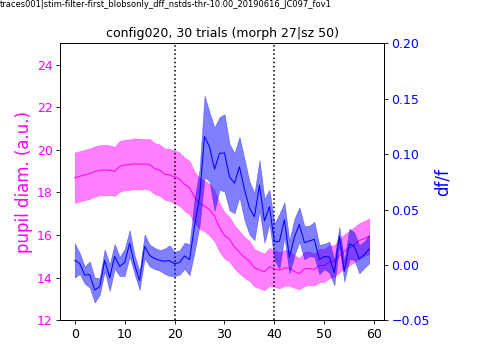

In [137]:
#for cfg, t_df in binned_pupil.groupby(['config']):
neural_color = 'blue'
pupil_color = 'magenta'

cfg = 'config020'
t_df = binned_pupil[binned_pupil['config']==cfg].copy()
cfg_ntrials = len(t_df['trial'].unique())


fig, ax =  pl.subplots()

p_traces = np.vstack([g['pupil'].values for t, g in t_df.groupby(['trial'])])
ntrials, nframes = p_traces.shape
ixs = np.arange(0, nframes)
ax.axvline(x=new_stim_on, ls=':', color='k')
ax.axvline(x=new_stim_on+new_n_on, ls=':', color='k')

# Plut pupil
ax.plot(ixs, p_traces.mean(axis=0), lw=1, color=pupil_color)
p_sem = spstats.sem(p_traces, axis=0)
ax.fill_between(ixs, p_traces.mean(axis=0)-p_sem, p_traces.mean(axis=0)+p_sem, 
                lw=.5, color=pupil_color, alpha=0.5)
ax.set_ylim([12, 25])
ax.tick_params(which='both', axis='y', labelcolor=pupil_color)
ax.set_ylabel('pupil diam. (a.u.)', color=pupil_color)


ax2 = ax.twinx()  
curr_trial_ixs = t_df['trial'].unique()
#mean_neural_traces = np.nanmean(binned_trialmat.loc[curr_trial_ixs].values.T, axis=1)
mean_neural_traces = binned_trialmat.loc[curr_trial_ixs].mean(axis=0).values
ax2.plot(mean_neural_traces, lw=1, color=neural_color)
n_sem = spstats.sem(binned_trialmat.loc[curr_trial_ixs].values, axis=0)
ax2.fill_between(ixs, mean_neural_traces-n_sem, mean_neural_traces+n_sem, 
                lw=.5, color=neural_color, alpha=0.5)
ax2.tick_params(which='both', axis='y', labelcolor=neural_color)
ax2.set_ylim([-0.05, 0.2])
ax2.set_ylabel('df/f', color=neural_color)

ax.set_title('%s, %i trials (morph %i|sz %i)' %(cfg, cfg_ntrials, sdf['morphlevel'][cfg], sdf['size'][cfg]))

putils.label_figure(fig, '%s_%s' % (data_id, datakey))

pl.subplots_adjust(right=0.8)

<IPython.core.display.Javascript object>


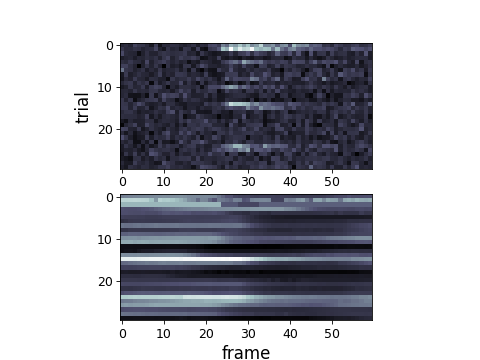

Text(0.5,0,u'frame')

In [140]:
fig, axn = pl.subplots(2, 1)
ax=axn[0]
ax.imshow(binned_trialmat.loc[trial_ixs], cmap='bone')
ax.set_ylabel('trial')

ax=axn[1]
ax.imshow(pupil_trialmat.loc[trial_ixs], cmap='bone')
ax.set_xlabel('frame')


In [336]:
binned_pupil.shape

(90000, 3)

<IPython.core.display.Javascript object>


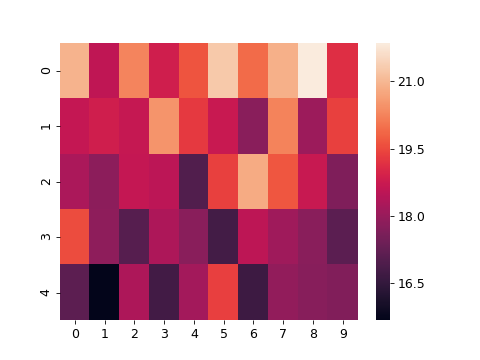

In [54]:
pl.figure()
sns.heatmap(binned_pupil.groupby(['config']).mean()['pupil'].reshape((10, 5)).T)


# Predict pupil?

In [48]:
mean_pupils = binned_pupil.groupby(['config', 'trial']).mean().reset_index()
mean_pupils.shape

(1500, 3)

<IPython.core.display.Javascript object>


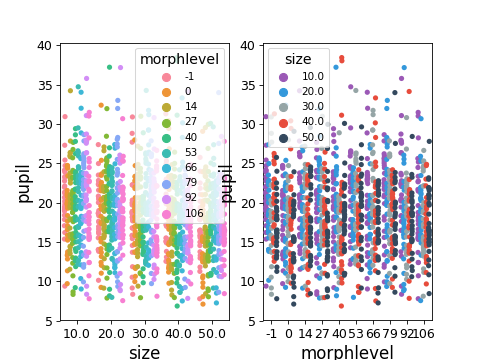

In [49]:
size_on_trials = [sdf['size'][c] for c in mean_pupils['config']]
morph_on_trials = [sdf['morphlevel'][c] for c in mean_pupils['config']]

mean_pupils['size'] = [sdf['size'][c] for c in mean_pupils['config']]
mean_pupils['morphlevel'] = [sdf['morphlevel'][c] for c in mean_pupils['config']]

fig, axn = pl.subplots(1, 2)
ax=axn[0]
sns.stripplot(x='size', y='pupil', hue='morphlevel', data=mean_pupils, ax=ax,
               marker='o', dodge=True)
ax=axn[1]
sns.stripplot(x='morphlevel', y='pupil', hue='size', data=mean_pupils, ax=ax,
               marker='o', dodge=True)


# Linear models

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics, linear_model, preprocessing
from sklearn.model_selection import StratifiedKFold


class Struct():
    pass

def fit_lasso_regr(xtrain, ytrain, xtest, ytest):
    regr = linear_model.Lasso()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    return ypred, regr

def fit_ridge_regr(xtrain, ytrain, xtest, ytest):
    regr = linear_model.Ridge()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    return ypred, regr

def fit_linear_regr(xtrain, ytrain, xtest, ytest):
    regr = linear_model.LinearRegression()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    return ypred, regr

def fit_logistic_regr(xtrain, ytrain, xtest, ytest):
    regr = linear_model.LogisticRegression()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    return ypred, regr


def get_regr_stats(X, ylabels, test_size=0.1, return_data=False, model='ols'):
    x_train, x_test, y_train, y_test = train_test_split(X, ylabels, test_size=test_size, random_state=0)
    if model=='ols':
        y_pred, regr = fit_linear_regr(x_train, y_train, x_test, y_test)
    elif model=='ridge':
        print("ridge")
        y_pred, regr = fit_ridge_regr(x_train, y_train, x_test, y_test)
    elif model=='lasso':
        print("lasso")
        y_pred, regr = fit_lasso_regr(x_train, y_train, x_test, y_test)
    elif model=='log':
        y_pred, regr = fit_logistic_regr(x_train, y_train, x_test, y_test)
        
        
    results = Struct()
    results.pearsons_r, results.pearsons_p = spstats.pearsonr(y_test, y_pred)
    results.exp_var = metrics.explained_variance_score(y_test, y_pred)
    results.mse = metrics.mean_squared_error(y_test, y_pred)
    results.r2 = metrics.r2_score(y_test, y_pred, multioutput='uniform_average')
    results.regr = regr
    results.prediction = y_pred
    results.true = y_test
    results.coef_ = regr.coef_
    results.intercept_ = regr.intercept_
    
    if return_data:
        data = {'x_train': x_train,
                'x_test': x_test,
                'y_train': y_train,
                'y_test': y_test}
        
        return results, data
    return results


ridge
ridge


<IPython.core.display.Javascript object>


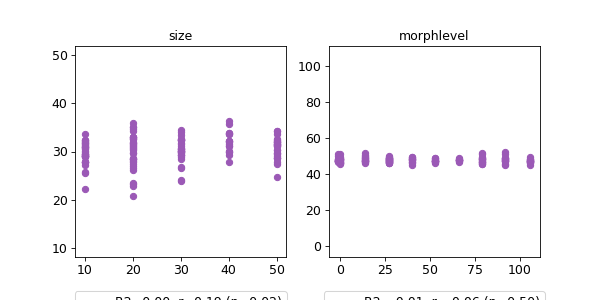

In [51]:
regr_var1 = 'size'
regr_var2 = 'morphlevel'
exclude_controls = True
model = 'ridge'

visual_areas = ['V1', 'Lm', 'Li']

targets1 = mean_pupils[regr_var1]
res1, data1 = get_regr_stats(mean_pupils['pupil'].reshape(-1, 1), targets1, return_data=True, model=model)

targets2 = mean_pupils[regr_var2]
res2, data2 = get_regr_stats(mean_pupils['pupil'].reshape(-1, 1), targets2, return_data=True, model=model)


# ---- plot --------------------------------------------__
fig, axes = pl.subplots(1, 2, figsize=(8,4))

ax = axes[0]
ax.set_title(regr_var1)
ax.scatter(res1.true, res1.prediction)
maxv = max([ax.get_xlim()[-1], ax.get_ylim()[-1]])
minv = min([ax.get_xlim()[0], ax.get_ylim()[0]])
ax.set_xlim([minv, maxv])
ax.set_ylim([minv, maxv])
pval_str = 'R2=%.2f, r=%.2f (p=%.2f)' % (res1.r2, res1.pearsons_r, res1.pearsons_p)
ax.plot(0, 0, alpha=0, label=pval_str)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.3), fontsize=12)

ax.set_aspect('equal')

ax = axes[1]
ax.set_title(regr_var2)
res_ = pd.DataFrame({'predicted': res2.prediction,
             'true': res2.true})
ax.scatter(res2.true, res2.prediction)
#sns.stripplot('true', 'predicted', data=res_, ax=ax, dodge=True)
maxv = max([ax.get_xlim()[-1], ax.get_ylim()[-1]])
minv = min([ax.get_xlim()[0], ax.get_ylim()[0]])
ax.set_xlim([minv, maxv])
ax.set_ylim([minv, maxv])
pval_str = 'R2=%.2f, r=%.2f (p=%.2f)' % (res2.r2, res2.pearsons_r, res2.pearsons_p)
ax.plot(0, 0, alpha=0, label=pval_str)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.3), fontsize=12)

ax.set_aspect('equal')



## Predict pupil from neural data

In [52]:
datakey
roi_list = [r for r in MEANS[datakey].columns if putils.isnumber(r)]
currdata = neuraldf[roi_list].copy()
X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(currdata))


In [53]:
targets = mean_pupils['pupil'].copy()
res1, data1 = get_regr_stats(X, targets, return_data=True, model='ridge')


ridge


<IPython.core.display.Javascript object>


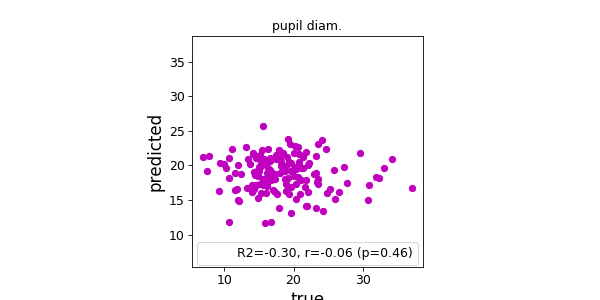

Text(0.5,0,u'true')

In [57]:
fig, ax = pl.subplots( figsize=(8,4))

ax.set_title('pupil diam.')
ax.scatter(res1.true, res1.prediction, c='m')
maxv = max([ax.get_xlim()[-1], ax.get_ylim()[-1]])
minv = min([ax.get_xlim()[0], ax.get_ylim()[0]])
ax.set_xlim([minv, maxv])
ax.set_ylim([minv, maxv])
pval_str = 'R2=%.2f, r=%.2f (p=%.2f)' % (res1.r2, res1.pearsons_r, res1.pearsons_p)
ax.plot(0, 0, alpha=0, label=pval_str)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.02), fontsize=12)
ax.set_aspect('equal')
ax.set_ylabel('predicted')
ax.set_xlabel('true')

#ax = putils.abline(res1.coef_, res1.intercept_, ax=ax, color='m')

# Get all rois and traces

In [58]:
pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
print(pupil_r.shape)



(90000, 3)


In [59]:
pupil_r['frame_int'] = [int(round(f)) for f in pupil_r['frame']]
interp_frame_ixs = list(sorted(pupil_r['frame'].unique()))
pupil_r['frame_ix'] = [interp_frame_ixs.index(f) for f in pupil_r['frame']]


In [60]:
r_list=[]
#rid=90
for rid in roi_list:
    # Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
    trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                            index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
    configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
    included_trials = [trial for trial, tg in labels.groupby(['trial'])]

    #### Bin traces - Each tbin is a column, each row is a sample 
#     sample_data = trialmat.fillna(method='pad').copy()
#     binned_trialmat = sample_data.T.groupby(np.arange(len(sample_data.columns))//n_frames_bin, axis=0).mean().T
#     n_tbins = np.ceil(trialmat.shape[1] / n_frames_bin)
    df = trialmat.fillna(method='pad').copy().T
    xdf = df.reindex(df.index.union(out_ixs)).interpolate('values').loc[out_ixs]
    binned_trialmat = xdf.T # should be Ntrials # Nframes
    n_tbins = binned_trialmat.shape[1]

    #### Zscore traces 
    zscored_neural = binned_trialmat / binned_trialmat.values.ravel().std()

    # Reshape roi traces
    cfg_list = np.hstack([[c for _ in np.arange(0, n_tbins)] for c in configs_on_included_trials])
    r_ = zscored_neural.T.unstack().reset_index() # level_0=trial number, level_1=frame number
    r_.rename(columns={'level_0': 'trial', 'level_1': 'frame', 0: rid}, inplace=True)
    r_list.append(r_)

# Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                        index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
included_trials = [trial for trial, tg in labels.groupby(['trial'])]


traces_r = pd.concat(r_list, axis=1)
print(r_.shape, traces_r.shape)
traces_r['config'] = cfg_list

_, dii = np.unique(traces_r.columns, return_index=True)
traces_r = traces_r.iloc[:, dii]
print(traces_r.shape)


((90000, 3), (90000, 888))
(90000, 299)


In [61]:
traces_r['frame_int'] = [int(round(f)) for f in traces_r['frame']]
interp_frame_ixs = list(sorted(pupil_r['frame'].unique()))
traces_r['frame_ix'] = [interp_frame_ixs.index(f) for f in traces_r['frame']]


#### Sort ROIs by correlation w/ pupil (for visualization)

In [62]:
pupil_values = pupil_r.sort_values(by=['trial', 'frame'])['pupil'].values

pupilcorrs = [np.corrcoef(traces_r.sort_values(by=['trial', 'frame_ix'])[rid], pupil_values)[0, 1] for rid in roi_list]


In [63]:
sorted_ixs = np.argsort(pupilcorrs)
# for ri in sorted_ixs:
#     print(ri, roi_list[ri], pupilcorrs[ri])
sorted_rids = np.array([roi_list[ri] for ri in sorted_ixs[::-1]])

In [64]:
# from matplotlib.colors import LinearSegmentedColormap

# cmap_name='nic_edge'
# cmap_dir='/n/coxfs01/julianarhee/aggregate-visual-areas/colormaps'

# #colormap = 'nic_Edge'
# #cmapdir = os.path.join(aggr_dir, 'colormaps')
# cdata = np.loadtxt(os.path.join(cmap_dir, cmap_name) + ".txt")
# cmap = LinearSegmentedColormap.from_list('my_colormap', cdata) #[::-1])
cmap='seismic'

In [65]:
new_stim_on, new_n_on

(20, 20)

In [66]:
on_frames = np.arange(new_stim_on, new_stim_on+new_n_on)
print(len(on_frames))
on_frames


20


array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39])

In [153]:
# plot_config = 'config022'
# plot_config = 'config020'
plot_config = None


if plot_config is not None:
    trial_ixs = traces_r[traces_r['config']==plot_config]['trial'].unique()
    #trial_ixs = sorted(pupil_r[pupil_r['trial'].isin(curr_trials)].unique())
else:
    trial_ixs = sorted(pupil_r['trial'].unique())

ntrials_plot = 30 if plot_config is None else len(trial_ixs)
start_trial = 0

plot_str = plot_config if plot_config is not None else 'consecutivetrials'
print(plot_str)

curr_trial_ixs = trial_ixs[start_trial:start_trial+ntrials_plot] if plot_config is None else trial_ixs
print("[%s] %i trials" % (plot_config, len(curr_trial_ixs)))


consecutivetrials
[None] 30 trials


<IPython.core.display.Javascript object>


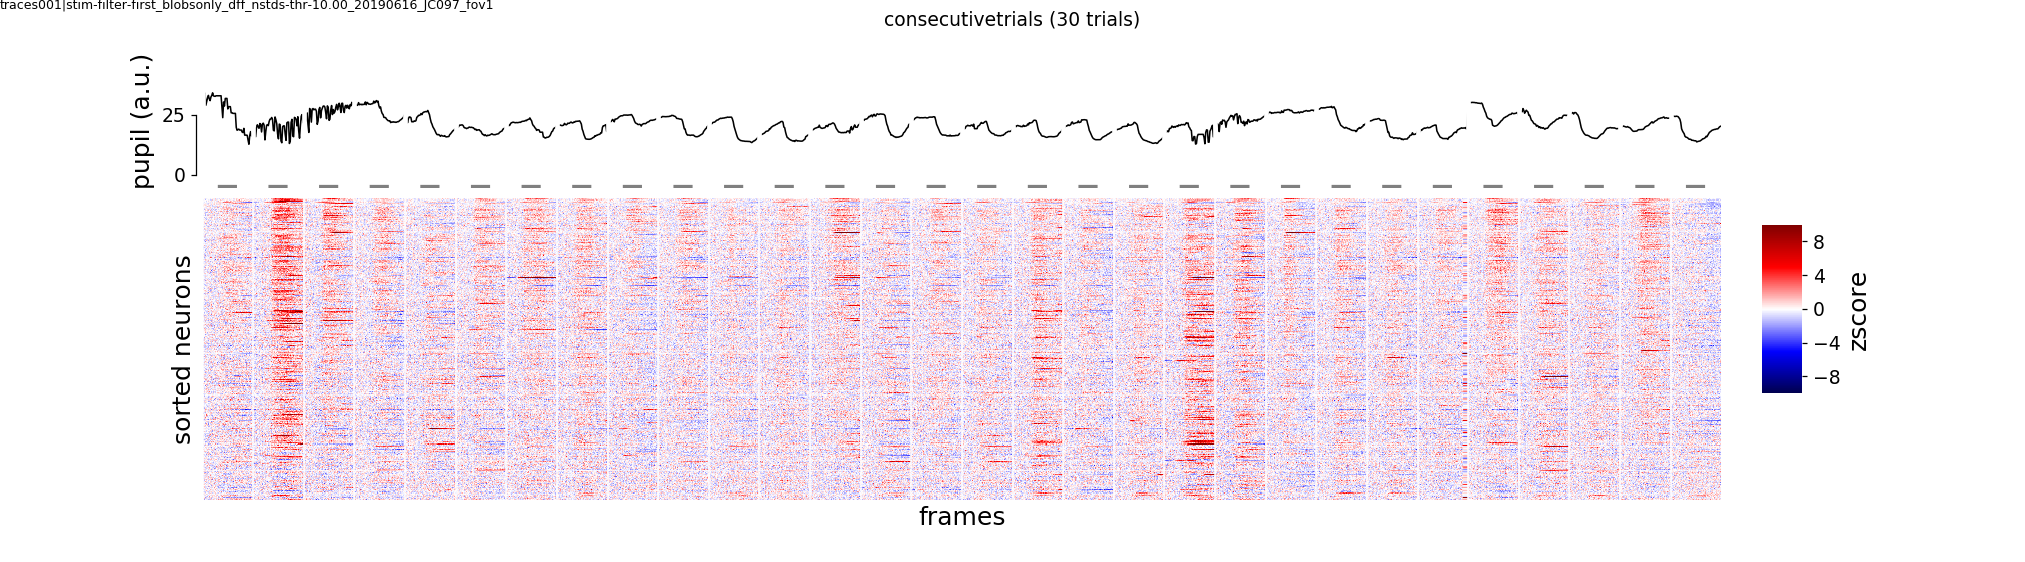

('/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/pupil', '20190616_JC097_fov1_consecutivetrials_sorted_neurons_pupil_trace_30trials_bin20fHz')


In [154]:

pupil_lw=1
stim_lw=2

curr_pupil_trace = pupil_r[pupil_r['trial'].isin(curr_trial_ixs)]['pupil'].values
stim_ixs = [1 if f in on_frames else np.nan for f in pupil_r[pupil_r['trial'].isin(curr_trial_ixs)]['frame_ix']]

curr_p = pupil_r[pupil_r['trial'].isin(curr_trial_ixs)].copy()
ix = curr_p.index.tolist()
on_ixs_global = [ix.index(i) for i in curr_p[curr_p['frame']==0].index.tolist()]
pvs = curr_pupil_trace.copy()
# pvs[on_ixs_global] = np.nan

#fig, ax = pl.subplots()
grid_kws = {"height_ratios": (.25, 0.05, .7), "hspace": .005}
fig, (ax1, stimax, ax0) = pl.subplots(3,1, gridspec_kw=grid_kws, figsize=(18,5), dpi=dpi, sharex=True)

# Plot neural traces (all neurons, sorted) as heatmap
cbar_ax = fig.add_axes([.87, .3, .02, .3])
im0 = sns.heatmap(traces_r[traces_r['trial'].isin(curr_trial_ixs)][sorted_rids].T, ax=ax0,
                  cmap=cmap, center=0, vmin=-10, vmax=10,
                  cbar_ax=cbar_ax, cbar_kws={'label': 'zscore'})
for ix in on_ixs_global:
    ax0.axvline(x=ix, color='w', lw=1)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_ylabel('sorted neurons')
ax0.set_xlabel('frames')

# Plot pupil traces
nframes_total=len(pupil_r)
#divider = make_axes_locatable(ax)
#topax = divider.append_axes("top", 1.2, pad=0.5, sharex=None) #scatterax) #None)
ax1.plot(np.arange(0, len(curr_pupil_trace)), pvs, lw=pupil_lw, color='k')
ax1.set_ylabel('pupil (a.u.)')
ax1.set_ylim([0, 45])
for ix in on_ixs_global:
    ax1.axvline(x=ix, color='w', lw=3)
    
# Plot stimulus onset bars
stimax.plot(np.arange(0, len(curr_pupil_trace)), stim_ixs, color='gray', lw=stim_lw)
stimax.tick_params(which='both', axis='both', size=0)
stimax.axis('off')

sns.despine(trim=True, bottom=True, ax=ax1, offset=4)
ax1.tick_params(axis='x', which='both', size=0)
ax1.set_xticks([])
pl.subplots_adjust(left=0.1, right=0.85)
fig.suptitle('%s (%i trials)' % (plot_str, ntrials_plot))

putils.label_figure(fig, '%s_%s' % (data_id, datakey))

figname = '%s_%s_sorted_neurons_pupil_trace_%itrials_bin%ifHz' % (datakey, plot_str, ntrials_plot, new_framerate)
pl.savefig(os.path.join(pupildir, '%s.png' % figname))
print(pupildir, figname)

In [86]:
data_id

'traces001|stim-filter-first_blobsonly_dff_nstds-thr-10.00'

In [ ]:
ntrials_plot = 20
start_trial = 0
pupil_lw=1
stim_lw=2

curr_trial_ixs = trial_ixs[start_trial:start_trial+ntrials_plot]
curr_pupil_trace = pupil_r[pupil_r['trial'].isin(curr_trial_ixs)].sort_values(by='trial')['pupil'].values
stim_ixs = [1 if f in on_frames else np.nan for f in pupil_r[pupil_r['trial'].isin(curr_trial_ixs)]['frame_ix']]

curr_p = pupil_r[pupil_r['trial'].isin(curr_trial_ixs)].copy()
ix = curr_p.index.tolist()
on_ixs_global = [ix.index(i) for i in curr_p[curr_p['frame']==0].index.tolist()]
pvs = curr_pupil_trace.copy()
pvs[on_ixs_global] = np.nan

#fig, ax = pl.subplots()
grid_kws = {"height_ratios": (.25, 0.05, .7), "hspace": .005}
fig, (ax1, stimax, ax0) = pl.subplots(3,1, gridspec_kw=grid_kws, figsize=(20,5), dpi=dpi, sharex=True)

cbar_ax = fig.add_axes([.87, .3, .02, .3])
#im0 = ax.imshow(traces_r[roi_list].T, cmap='bone', aspect=200, vmin=-10, vmax=10)
#pl.colorbar(im0, ax=ax)
im0 = sns.heatmap(traces_r[traces_r['trial'].isin(curr_trial_ixs)][sorted_rids].T, ax=ax0,
                  cmap=cmap, center=0, vmin=-10, vmax=10,
                  cbar_ax=cbar_ax, cbar_kws={'label': 'zscore'})
for ix in on_ixs_global:
    ax0.axvline(x=ix, color='w')
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_ylabel('sorted neurons')
ax0.set_xlabel('frames')
             
nframes_total=len(pupil_r)
#divider = make_axes_locatable(ax)
#topax = divider.append_axes("top", 1.2, pad=0.5, sharex=None) #scatterax) #None)
ax1.plot(np.arange(0, len(curr_pupil_trace)), pvs, lw=pupil_lw, color='k')
ax1.set_ylabel('pupil (a.u.)')
#ax1.set_ylim([0, 50])

stimax.plot(np.arange(0, len(curr_pupil_trace)), stim_ixs, color='gray', lw=stim_lw)
stimax.tick_params(which='both', axis='both', size=0)
stimax.axis('off')


sns.despine(trim=True, bottom=True, ax=ax1, offset=4)
ax1.tick_params(axis='x', which='both', size=0)
ax1.set_xticks([])
pl.subplots_adjust(left=0.1, right=0.8)
fig.suptitle('%i trials' % ntrials_plot)


figname = '%s_sorted_neurons_pupil_trace_%itrials_bin%ifHz' % (datakey, ntrials_plot, new_framerate)
pl.savefig(os.path.join(pupildir, '%s.png' % figname))
print(pupildir, figname)

# Predict timecourse of pupil from neural data?

In [142]:
from sklearn.model_selection import GroupKFold

In [143]:
print(traces_r.shape, pupil_r.shape)
traces_r.head()


((90000, 301), (90000, 5))


,0,1,2,3,4,5,6,7,8,9,...,423,424,425,426,431,config,frame,trial,frame_int,frame_ix
0,0.184304,0.443776,0.101527,0.334589,-0.120514,-0.030210,0.834548,-1.107893,0.727642,0.482937,...,1.036999,0.857312,0.262095,0.603493,0.316486,config004,0.000000,1,0,0
1,-0.496884,-1.278281,0.119737,-0.882493,0.620354,0.414988,-0.583668,-0.442248,-0.221285,-1.302858,...,-0.373219,-1.219070,-0.130620,0.945848,-0.037501,config004,2.271186,1,2,1
2,0.111335,0.481243,0.461598,-0.575738,-0.627820,0.197481,0.111907,-0.641268,0.390237,-0.839174,...,-1.303407,-0.382167,-0.978617,1.209853,-0.380543,config004,4.542373,1,5,2
3,0.351031,0.585230,0.229904,0.330824,-0.274369,1.374529,-1.412427,-0.193406,-1.579748,1.305174,...,0.848906,-0.892719,-0.400818,0.372830,-0.701054,config004,6.813559,1,7,3
4,0.859481,-0.164270,0.398303,0.877019,-0.926989,0.804197,-0.013329,0.276446,-0.228122,-1.600152,...,-0.980043,0.123547,-0.722893,-0.849886,0.875485,config004,9.084746,1,9,4


In [144]:
pupil_r.head()

,trial,frame,pupil,frame_int,frame_ix
0,1,0.000000,33.363709,0,0
1,1,2.271186,33.359263,2,1
2,1,4.542373,33.837850,5,2
3,1,6.813559,34.106828,7,3
4,1,9.084746,29.055174,9,4


In [71]:
groups = pupil_r['trial']
group_kfold = GroupKFold(n_splits=2)

X = traces_r.copy() #[roi_list].copy()
y = pupil_r['pupil'].values

group_kfold.get_n_splits(X, y, groups)
for train_index, test_index in group_kfold.split(X, y, groups):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print(X_train, X_test)

<IPython.core.display.Javascript object>


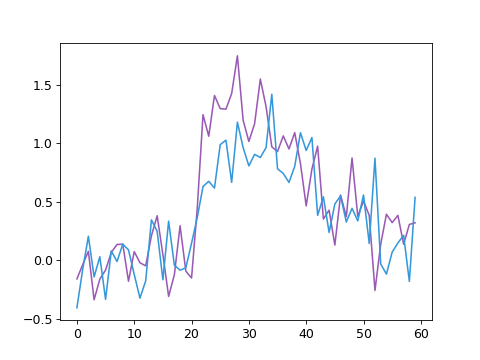

In [93]:
pl.figure()
pl.plot(np.vstack([g[90] for v, g in X_train[X_train['config']=='config022'].groupby(['trial'])]).mean(axis=0))
pl.plot(np.vstack([g[90] for v, g in X_test[X_test['config']=='config022'].groupby(['trial'])]).mean(axis=0))



In [156]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

import scipy.stats as spstats
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

import sklearn.metrics as skmetrics

In [147]:
train_x, test_x, train_y, test_y = train_test_split(traces_r, pupil_r['pupil'], test_size=0.2)


In [148]:
traces_r.shape, train_x.shape, test_x.shape

((90000, 301), (72000, 301), (18000, 301))

In [149]:
roi_list = [r for r in traces_r.columns if putils.isnumber(r)]


In [161]:
iter_results=[]
# Get data and labels
groups = pupil_r['trial']
group_kfold = GroupKFold(n_splits=2)

X = traces_r.copy() #[roi_list].copy()
y = pupil_r['pupil'].values
roi_list = [r for r in traces_r.columns if putils.isnumber(r)]

group_kfold.get_n_splits(X, y, groups)
for train_index, test_index in group_kfold.split(X, y, groups):
    X_train, X_test = X.loc[train_index][roi_list], X.loc[test_index][roi_list]
    train_labels, test_labels = y[train_index], y[test_index]
    #print(X_train, X_test)

    #### DATA - Fit classifier
    scaler = StandardScaler()
    scaler.fit(X_train)
    train_data = scaler.transform(X_train)
    svc = LinearRegression() #, penalty='l2')
    scores = cross_validate(svc, train_data, train_labels, cv=5,
                            scoring=('r2', 'neg_mean_squared_error'),
                            return_train_score=True)
    iterdict = dict((s, values.mean()) for s, values in scores.items())

    #### DATA - Test with held-out data
    test_data = scaler.transform(X_test)
    trained_svc = LinearRegression().fit(train_data, train_labels)
    test_score = trained_svc.score(test_data, test_labels)

    #### DATA - Calculate MI
    predicted_labels = trained_svc.predict(test_data)
    mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
    ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
    log2_mi = computeMI(test_labels, predicted_labels)

    iterdict.update({'heldout_test_score': test_score, 
                     'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
    iter_results.append(pd.DataFrame(iterdict, index=[iteration]))


# #% Train/validation split
# n_splits = 5 #len(X)
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) #KFold(n_splits=n_splits)
# kf.get_n_splits(train_x) #(X)

# # Do K-fold CV for current stimulus configs
# scores=[]
# test_scores = [] #dict((tv, []) for tv in tested_sizes)
# for train_index, validate_index in kf.split(train_x, train_y): #(X, y): #kf.split(X):

#     # Get current train/validate split data
# #                     X_train, X_validate = X[train_index], X[validate_index]
# #                     y_train, y_validate = y[train_index], y[validate_index]
#     X_train, X_validate = train_x[train_index], train_x[validate_index]
#     y_train, y_validate = train_y[train_index], train_y[validate_index]

#     scaler = preprocessing.StandardScaler().fit(X_train)
#     X_train_transformed = scaler.transform(X_train)

#     # Fit SVM
#     trained_svc = LinearRegression(C=C_value).fit(X_train_transformed, y_train)

#     # Validate with held-out data
#     X_validate_transformed = scaler.transform(X_validate)
#     curr_score = trained_svc.score(X_validate_transformed, y_validate)  
#     y_pred = trained_svc.predict(X_validate_transformed)

#     # Add current fold score
#     test_scores.append(curr_score)


MemoryError: 

In [174]:
scores

{'fit_time': array([ 1.441787  ,  2.05968404,  1.5969429 ,  1.73612309,  1.71120906]),
 'score_time': array([ 0.00806689,  0.00947094,  0.01095319,  0.02040505,  0.00982285]),
 'test_neg_mean_squared_error': array([-24.47388561, -27.39212099, -33.33938681, -32.01179972, -37.24117864]),
 'test_r2': array([-0.03276524,  0.07701976, -0.00049881,  0.03276712,  0.06353265]),
 'train_neg_mean_squared_error': array([-30.2575073 , -29.39523891, -27.97060108, -28.34635655, -27.00753485]),
 'train_r2': array([ 0.11476885,  0.11188175,  0.13035   ,  0.11321507,  0.11473068])}

In [163]:
predicted_labels = trained_svc.predict(test_data) #, test_labels)

In [164]:
len(predicted_labels), len(test_labels)

(45000, 45000)

<IPython.core.display.Javascript object>


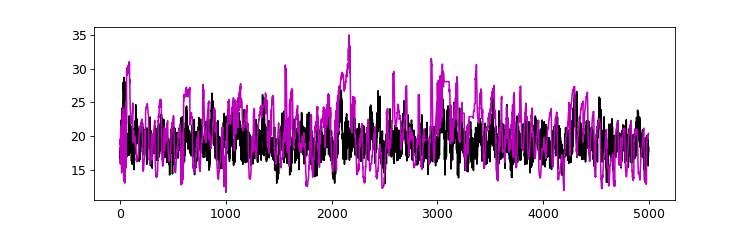

In [173]:
pl.figure(figsize=(10,3))
pl.plot(predicted_labels[0:5000], 'k')
pl.plot(test_labels[0:5000], 'm')

# Create data frames for pupil/neural data - test low/high pupil

In [94]:
# neuraldf = pd.concat([g[roi_list].mean(axis=0) for t, g in traces_r.groupby(['trial'])], axis=1).T
# print(neuraldf.shape)
# config_list = [g['config'].unique()[0] for t, g in traces_r.groupby(['trial'])]
print(datakey)
neuraldf=MEANS[datakey].copy()

pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
print(pupildf.shape)


20190616_JC097_fov1
(1500, 5)


## Subdivide pupil levels into high/low

In [95]:
pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])

<IPython.core.display.Javascript object>


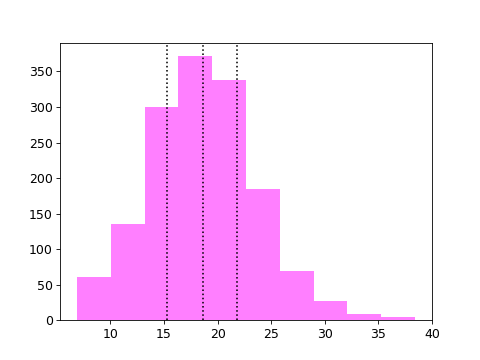

In [96]:
fig, ax = pl.subplots()
ax.hist(pupildf['pupil'], color='magenta', alpha=0.5)
for v in pupil_quantiles:
    ax.axvline(x=v, ls=':', color='k')

In [198]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

import scipy.stats as spstats
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import sklearn.metrics as skmetrics

In [97]:
import sklearn.metrics as skmetrics
import random

def computeMI(x, y):
    sum_mi = 0.0
    x_value_list = np.unique(x)
    y_value_list = np.unique(y)
    Px = np.array([ len(x[x==xval])/float(len(x)) for xval in x_value_list ]) #P(x)
    Py = np.array([ len(y[y==yval])/float(len(y)) for yval in y_value_list ]) #P(y)
    for i in xrange(len(x_value_list)):
        if Px[i] ==0.:
            continue
        sy = y[x == x_value_list[i]]
        if len(sy)== 0:
            continue
        pxy = np.array([len(sy[sy==yval])/float(len(y))  for yval in y_value_list]) #p(x,y)
        t = pxy[Py>0.]/Py[Py>0.] /Px[i] # log(P(x,y)/( P(x)*P(y))
        sum_mi += sum(pxy[t>0]*np.log2( t[t>0]) ) # sum ( P(x,y)* log(P(x,y)/( P(x)*P(y)) )
    return sum_mi

In [141]:
def fit_svm(curr_data, sdf, m0=0, m100=106, C_value=1.0, n_iterations=100):
    iter_results=[]
    iter_results_chance=[]
    for iteration in np.arange(0, n_iterations):

        #### Select train/test configs for clf A vs B
        object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
        curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
        sample_data = curr_data[curr_data['config'].isin(object_configs)]

        #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
        data = sample_data[curr_roi_list]
        zdata = (data - data.mean()) / data.std()


        #### Get labels
        targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
        targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]
        targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]

        stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
        sizes = sorted(stimdf['size'].unique())

        #### For each transformation, split trials into 80% and 20%
        train_data=[]; test_data=[]; 
        train_labels=[]; test_labels=[]; 
        train_data_chance=[]; test_data_chance=[]; 
        train_labels_chance=[]; test_labels_chance=[]; 
        train_data, test_data, train_labels, test_labels = train_test_split(zdata, targets['label'].values, 
                                                            test_size=0.2, stratify=targets['group'])


#         for sz in sizes: 
#             curr_configs = sdf[sdf['size']==sz].index.tolist()
#             curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
#             xi = zdata.loc[curr_trials]
#             yi = targets.loc[curr_trials]['label'].values

#             # Split train/test
#             train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2, startify=)
#             train_data.append(train_x)
#             test_data.append(test_x)
#             train_labels.append(train_y)
#             test_labels.append(test_y)
#         # Aggregate TRAIN/TEST data   
#         train_data = np.vstack(train_data)
#         train_labels = np.hstack(train_labels)
#         test_data = np.vstack(test_data)
#         test_labels = np.hstack(test_labels)

        #### DATA - Fit classifier
        scaler = StandardScaler()
        scaler.fit(train_data)
        train_data = scaler.transform(train_data)
        svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
        scores = cross_validate(svc, train_data, train_labels, cv=5,
                                scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                return_train_score=True)
        iterdict = dict((s, values.mean()) for s, values in scores.items())

        #### DATA - Test with held-out data
        test_data = scaler.transform(test_data)
        trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
        test_score = trained_svc.score(test_data, test_labels)

        #### DATA - Calculate MI
        predicted_labels = trained_svc.predict(test_data)
        mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
        ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
        log2_mi = computeMI(test_labels, predicted_labels)

        iterdict.update({'heldout_test_score': test_score, 
                         'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
        iter_results.append(pd.DataFrame(iterdict, index=[iteration]))

        # ------------------------------------------------------------------
        # Shuffle LABELS to calculate chance level
        train_labels_chance = train_labels.copy()
        np.random.shuffle(train_labels_chance)
        test_labels_chance = test_labels.copy()
        np.random.shuffle(test_labels_chance)

        #### CHANCE - Fit classifier
        svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
        scores_chance = cross_validate(svc, train_data, train_labels_chance, cv=5,
                                scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                return_train_score=True)
        iterdict_chance = dict((s, values.mean()) for s, values in scores_chance.items())

        # CHANCE - Test with held-out data
        trained_svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels_chance)
        test_score_chance = trained_svc_chance.score(test_data, test_labels_chance)  

        # Chance - Calculate MI
        predicted_labels = trained_svc_chance.predict(test_data)
        mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
        ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
        log2_mi = computeMI(test_labels, predicted_labels)

        iterdict_chance.update({'heldout_test_score': test_score_chance, 
                                'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
        iter_results_chance.append(pd.DataFrame(iterdict_chance, index=[iteration]))

    # DATA - get mean across iters
    df = pd.concat(iter_results, axis=0)
    df_chance = pd.concat(iter_results_chance, axis=0)
    
    return df, df_chance


# def fit_svm(curr_data, sdf, m0=0, m100=106, C_value=1.0, n_iterations=100):

#     iter_results=[]
#     iter_results_chance=[]
#     for iteration in np.arange(0, n_iterations):

#         #### Select train/test configs for clf A vs B
#         object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
#         curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
#         sample_data = curr_data[curr_data['config'].isin(object_configs)]

#         #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
#         zdata = sample_data[curr_roi_list]
#         #zdata = (data - data.mean()) / data.std()

#         #### Get labels
#         targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
#         targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

#         stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
#         sizes = sorted(stimdf['size'].unique())

#         #### For each transformation, split trials into 80% and 20%
#         train_data=[]; test_data=[]; 
#         train_labels=[]; test_labels=[]; 
#         train_data_chance=[]; test_data_chance=[]; 
#         train_labels_chance=[]; test_labels_chance=[]; 
#         for sz in sizes: 
#             curr_configs = sdf[sdf['size']==sz].index.tolist()
#             curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
#             xi = zdata.loc[curr_trials]
#             yi = targets.loc[curr_trials]['label'].values

#             # Split train/test
#             train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)
#             train_data.append(train_x)
#             test_data.append(test_x)
#             train_labels.append(train_y)
#             test_labels.append(test_y)

#         # Aggregate TRAIN/TEST data        
#         train_data = np.vstack(train_data)
#         train_labels = np.hstack(train_labels)
#         test_data = np.vstack(test_data)
#         test_labels = np.hstack(test_labels)

#         #### DATA - Fit classifier
#         svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
#         scores = cross_validate(svc, train_data, train_labels, cv=5,
#                                 scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
#                                 return_train_score=True)
#         iterdict = dict((s, values.mean()) for s, values in scores.items())

#         #### DATA - Test with held-out data
#         trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
#         test_score = trained_svc.score(test_data, test_labels)

#         #### DATA - Calculate MI
#         predicted_labels = trained_svc.predict(test_data)
#         mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
#         ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
#         log2_mi = computeMI(test_labels, predicted_labels)

#         iterdict.update({'heldout_test_score': test_score, 
#                          'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
#         iter_results.append(pd.DataFrame(iterdict, index=[iteration]))

#         # ------------------------------------------------------------------
#         # Shuffle LABELS to calculate chance level
#         train_labels_chance = train_labels.copy()
#         np.random.shuffle(train_labels_chance)
#         test_labels_chance = test_labels.copy()
#         np.random.shuffle(test_labels_chance)

#         #### CHANCE - Fit classifier
#         svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
#         scores_chance = cross_validate(svc, train_data, train_labels_chance, cv=5,
#                                 scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
#                                 return_train_score=True)
#         iterdict_chance = dict((s, values.mean()) for s, values in scores_chance.items())

#         # CHANCE - Test with held-out data
#         trained_svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels_chance)
#         test_score_chance = trained_svc_chance.score(test_data, test_labels_chance)  

#         # Chance - Calculate MI
#         predicted_labels = trained_svc_chance.predict(test_data)
#         mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
#         ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
#         log2_mi = computeMI(test_labels, predicted_labels)

#         iterdict_chance.update({'heldout_test_score': test_score_chance, 
#                                 'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
#         iter_results_chance.append(pd.DataFrame(iterdict_chance, index=[iteration]))

#     # DATA - get mean across iters
#     df = pd.concat(iter_results, axis=0)
#     df_chance = pd.concat(iter_results_chance, axis=0)
    
#     return df, df_chance


In [101]:
low_pupil_thr = pupil_quantiles[0.25]
high_pupil_thr = pupil_quantiles[0.75]

pupil_low = pupildf[pupildf['pupil']<low_pupil_thr].copy()
pupil_high = pupildf[pupildf['pupil']>high_pupil_thr].copy()

# Get trial indices of low/high pupil 
low_trial_ixs = sorted(pupil_low['trial'].unique())
high_trial_ixs = sorted(pupil_high['trial'].unique())

#print(pupil_low.shape, pupil_high.shape)


In [104]:
m0=0
m100=106
C_value=1

n_iterations = 50

In [105]:
curr_data = neuraldf.copy()
df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)

# Fit LOW
curr_data = neuraldf.loc[low_trial_ixs].copy()
lo, lo_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)


# Fit HIGH
curr_data = neuraldf.loc[high_trial_ixs].copy()
hi, hi_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:

metric='heldout_test_score'
print("all: %.2f (chance=%.2f)" % (df.mean()[metric], df_chance.mean()[metric]))
print("low: %.2f (chance=%.2f)" % (lo.mean()[metric], lo_chance.mean()[metric]))
print("high: %.2f (chance=%.2f)" % (hi.mean()[metric], hi_chance.mean()[metric]))


In [227]:
m0=0
m100=106
C_value=1
n_iterations = 50
skip = [] # ['20190420_JC076_fov1']

curr_dsets = dsets[dsets['visual_area']=='V1'].copy()
d_list=[]; d_list_chance=[]; dkeys=[];
lo_list=[]; lo_list_chance=[]; 
hi_list=[]; hi_list_chance=[]; 
n_datakeys = len(curr_dsets['datakey'].unique())

for di, (datakey, ds) in enumerate(curr_dsets.groupby(['datakey'])):
    if datakey in skip:
        continue
    
    if di % 5 == 0:
        print("%i of %i datakeys" % (int(di+1), n_datakeys))
        
    neuraldf = MEANS[datakey].copy() 
    
    # ------ PUPIL --------------------------------------------------
    pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()
    # Resample pupil traces
    binned_pupil = resample_pupil_traces(pupiltraces, in_rate=20.0, out_rate=new_framerate)
    # binned_trialmat.shape # Ntrials # Nframes
    trials_ = sorted(pupiltraces['trial'].unique())
    new_nframes_per_trial = binned_pupil.shape[0]/float(len(trials_))
    frames_ = np.arange(0, new_nframes_per_trial)
    pupil_trialmat = pd.DataFrame(np.vstack([p['pupil'].values for trial, p in binned_pupil.groupby(['trial'])]),
                                  index=trials_, columns=frames_)
                                  #index=binned_trialmat.index, columns=binned_trialmat.columns)
    pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
    pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
    
    # ------ Split trials by quantiles ---------------------------------
    pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])
    low_pupil_thr = pupil_quantiles[0.25]
    high_pupil_thr = pupil_quantiles[0.75]
    pupil_low = pupildf[pupildf['pupil']<low_pupil_thr].copy()
    pupil_high = pupildf[pupildf['pupil']>high_pupil_thr].copy()

    # Get trial indices of low/high pupil 
    low_trial_ixs = sorted(pupil_low['trial'].unique())
    high_trial_ixs = sorted(pupil_high['trial'].unique())
    
    # Fit all
    curr_data = neuraldf.copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("all: %.2f (chance=%.2f)" % (df.mean()['heldout_aMI'], df_chance.mean()['heldout_aMI']))
    d_list.append(df.mean(axis=0).T)
    d_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[low_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("low: %.2f (chance=%.2f)" % (df.mean()['heldout_aMI'], df_chance.mean()['heldout_aMI']))
    lo_list.append(df.mean(axis=0).T)
    lo_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[high_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("high: %.2f (chance=%.2f)" % (df.mean()['heldout_aMI'], df_chance.mean()['heldout_aMI']))
    hi_list.append(df.mean(axis=0).T)
    hi_list_chance.append(df_chance.mean(axis=0).T)
    
    dkeys.append(datakey)


all: 0.50 (chance=0.01)
low: 0.42 (chance=0.03)
low: 0.32 (chance=0.00)
all: 0.29 (chance=0.01)
low: 0.07 (chance=0.02)
low: 0.18 (chance=0.01)
all: 0.16 (chance=0.00)
low: 0.03 (chance=0.02)
low: 0.02 (chance=0.01)
all: 0.28 (chance=0.00)
low: 0.01 (chance=0.01)
low: 0.10 (chance=0.01)
6 of 7 datakeys
all: 0.18 (chance=0.01)
low: 0.13 (chance=0.01)
low: -0.00 (chance=-0.01)
all: 0.10 (chance=0.00)
low: 0.00 (chance=-0.01)
low: 0.09 (chance=0.04)


In [228]:
print(d_list[0].shape)
full_df = pd.concat(d_list, axis=1).T
full_chance = pd.concat(d_list_chance, axis=1).T
full_df['datakey'] = dkeys
full_chance['datakey'] = dkeys

lo_df = pd.concat(lo_list, axis=1).T
lo_chance = pd.concat(lo_list_chance, axis=1).T
lo_df['datakey'] = dkeys
lo_chance['datakey'] = dkeys

hi_df = pd.concat(hi_list, axis=1).T
hi_chance = pd.concat(hi_list_chance, axis=1).T
hi_df['datakey'] = dkeys
hi_chance['datakey'] = dkeys



(12,)


In [301]:
full_df.head()

,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2,datakey
0,0.004758,0.346440,0.495467,0.499807,0.883333,0.000863,0.808250,-2154.507472,0.232264,0.966761,-373.468449,0.866928,20190507_JC083_fov1
1,0.006810,0.206706,0.290534,0.298214,0.799000,0.000899,0.769239,-2592.829378,0.076043,0.930379,-782.257217,0.721258,20190522_JC084_fov1
2,0.006232,0.115261,0.156263,0.166286,0.726000,0.000891,0.703518,-3331.269901,-0.186951,0.884893,-1293.341367,0.539197,20190613_JC097_fov1
3,0.009844,0.196752,0.276214,0.283853,0.794667,0.001849,0.744406,-2871.858744,-0.023066,0.960357,-445.425505,0.841325,20190616_JC097_fov1
4,0.009995,0.129689,0.177963,0.187102,0.742333,0.002172,0.709607,-3262.854956,-0.162705,0.967491,-365.268858,0.869845,20190622_JC085_fov1


In [304]:
metric='heldout_test_score'

m_ = pd.concat([full_df[[metric]], lo_df[metric], hi_df[metric]], axis=1)
m_.columns = ['all', 'low', 'high']
# m_df['datakey'] = full_df['datakey']
m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})

m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]


<IPython.core.display.Javascript object>


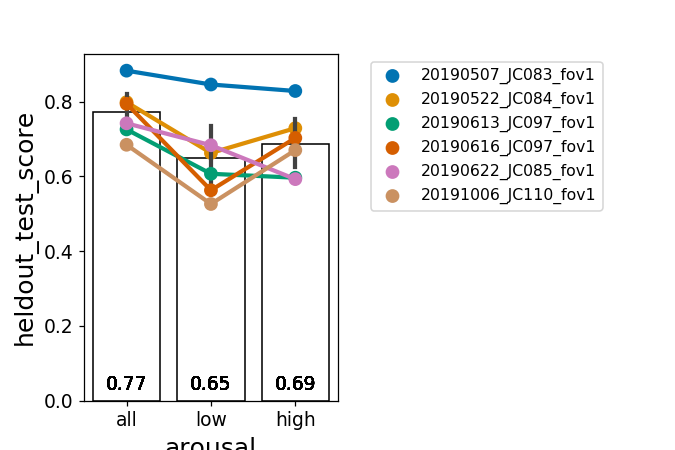

In [305]:
fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, palette='colorblind',
             s=10)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
ax.legend(bbox_to_anchor=(1.1, 1))

pl.subplots_adjust(right=0.5)

<IPython.core.display.Javascript object>


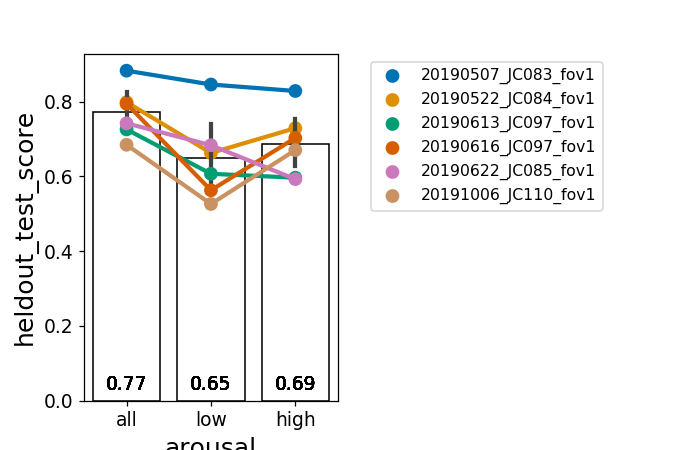

In [306]:
fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, palette='colorblind',
             s=10)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
ax.legend(bbox_to_anchor=(1.1, 1))

pl.subplots_adjust(right=0.5)

<IPython.core.display.Javascript object>


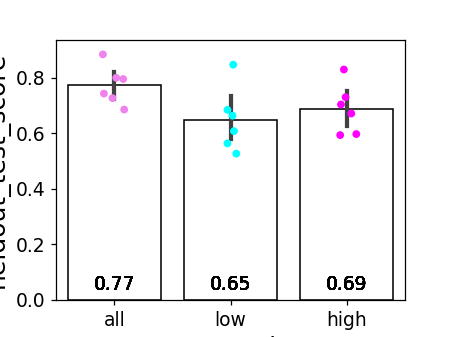

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
dtype: object

In [307]:
pupil_colors={'all': 'violet', 'low': 'aqua', 'high': 'magenta'}
fig, ax = pl.subplots(figsize=(4,3), dpi=dpi)
sns.stripplot(x='arousal', y=metric, data=m_df, ax=ax, palette=pupil_colors)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')


In [293]:
multi_comp_test='fdr_bh'
# Annotate w stats
print("********* [%s|%s] *********" % (experiment, metric))
#y_loc = 16 if fov_means else 23
statresults = aggr.do_mannwhitney(m_df, metric=metric, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax) #, y_loc=y_loc, offset=1)


********* [blobs|heldout_aMI] *********


KeyError: 'visual_area'

# Load RF data

In [ ]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.rois.utils import load_roi_coords

In [ ]:
reliable_only = True
#rfs_filter_by = None # Get all # match <EXP> datasets # 'drop_repeats'
rf_fit_thr = 0.05
fit_desc = fitrf.get_fit_desc(response_type=response_type)
reliable_str = 'reliable' if reliable_only else ''
rf_str = 'match%s_%s' % (experiment, reliable_str)
print(rf_str)


#### Get non-repeated FOV datasets
rf_dsets = sdata_exp[(sdata_exp['datakey'].isin(stim_datakeys))
                     & (sdata_exp['experiment'].isin(['rfs', 'rfs10']))].copy()
rf_dpaths, no_fits = rfutils.get_fit_dpaths(rf_dsets, traceid=traceid, fit_desc=fit_desc)
print("%i with no fits" % len(no_fits))

rfdf = rfutils.aggregate_rf_data(rf_dpaths, reliable_only=reliable_only, fit_desc=fit_desc,
                                            traceid=traceid, verbose=False)
rfdf = rfdf.reset_index(drop=True)

#### Get position info

In [ ]:
#if get_positions:
print("Calculating RF coord conversions...")
pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
for p in pos_params:
    rfdf[p] = ''
p_list=[]
for (animalid, session, fovnum), g in rfdf.groupby(['animalid', 'session', 'fovnum']):
    fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                              traceid=traceid, create_new=False)

    for ei, e_df in g.groupby(['experiment']):
        cell_ids = e_df['cell'].unique()
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            rfdf[p][e_df.index] = p_[p].values
# with open(df_fpath, 'wb') as f:
#     pkl.dump(expdf, f, protocol=pkl.HIGHEST_PROTOCOL)

#### Select subset of RF data

In [ ]:
r_list=[]
for datakey, expdf in corrs.groupby(['datakey']):
    # Get active blob cells
    exp_rids = sorted(np.union1d(expdf['row'].unique(), expdf['col'].unique()))    
    # Get current fov's RFs
    rdf = rfdf[rfdf['datakey']==datakey].copy()
    
    # If have both rfs/rfs10, pick the best one
    if len(rdf['experiment'].unique())>1:
        rf_rids = rdf[rdf['experiment']=='rfs']['cell'].unique()
        rf10_rids = rdf[rdf['experiment']=='rfs10']['cell'].unique()
        same_as_rfs = np.intersect1d(rf_rids, exp_rids)
        same_as_rfs10 = np.intersect1d(rf10_rids, exp_rids)
        rfname = 'rfs' if len(same_as_rfs) > len(same_as_rfs10) else 'rfs10'
        print("Selecting %s, overlappig rfs, %i | rfs10, %i (of %i cells)" 
              % (rfname, len(same_as_rfs), len(same_as_rfs10), len(exp_rids)))
        r_list.append(rdf[rdf['experiment']==rfname])
    else:
        r_list.append(rdf)
RFs = pd.concat(r_list, axis=0)


#### Calculate overlap 

In [ ]:
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
n_dks = len(RFs['datakey'].unique())

o_list=[]
for di, ((visual_area, animalid, session, fovnum, datakey), g) in enumerate(RFs.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey'])):
    if di%10==0:
        print("... %i of %i" % (int(di+1), n_dks))
        
    # convert RF fit params to polygon
    g.index = g['cell'].values
    rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

    # Get all pairwise overlaps (% of smaller ellipse that overlaps larger ellipse)
    pair_ixs = list(itertools.combinations(np.arange(0, len(rf_polys)), 2))
    overlaps = pd.concat([rfutils.get_proportion_overlap(rf_polys[p1], rf_polys[p2]) for (p1, p2) in pair_ixs], axis=0)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    o_ = putils.add_meta_to_df(overlaps, metadict)
    o_list.append(o_)

overlaps = pd.concat(o_list, axis=0).reset_index(drop=True)